In [1]:
import numpy as np
import pandas as pd 
import re
import nltk 
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential 
from keras.layers.core import Activation , Dense , Dropout
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


In [6]:
movie_reviews = pd.read_csv("/content/IMDB Dataset.csv",engine='python',encoding='utf-8')
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [7]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
movie_reviews['review'][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

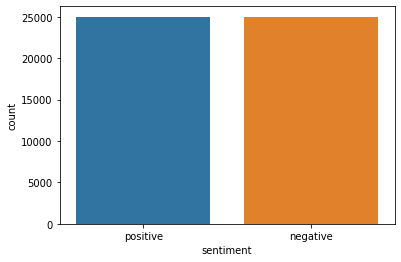

In [9]:
import seaborn as sns 
sns.countplot(x='sentiment',data=movie_reviews)

In [10]:
#Data Preprocessing and Cleaning 
def preprocess_text(sen):
  #Removing Html tags 
  sentence = remove_tags(sen)

  #Removing punctuations and numbers
  sentence = re.sub('[^a-zA-Z]',' ',sentence)

  #Single character removal 
  sentence = re.sub(r"\s+[a-zA-Z]\s"," ",sentence)

  #Removing Multiple Spaces 
  sentence = re.sub(r'\s+',' ', sentence)

  return sentence

In [11]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
  return TAG_RE.sub('',text)

In [13]:
review = []
sentences  = list(movie_reviews['review'])
for sen in sentences:
  review.append(preprocess_text(sen))

In [14]:
review[4]

'Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us vivid portrait about human relations This is movie that seems to be telling us what money power and success do to people in the different situations we encounter This being variation on the Arthur Schnitzler play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounter The acting is good under

In [16]:
converted = movie_reviews['sentiment']
converted = np.array(list(map(lambda x: 1 if x=='positive'  else 0,converted)))

In [17]:
review_train , review_test , converted_train , converted_test = train_test_split(review,converted,test_size = 0.20 , random_state= 0 )


In [18]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)

review_train = tokenizer.texts_to_sequences(review_train)
review_test = tokenizer.texts_to_sequences(review_test)


In [21]:
vocab_size = len(tokenizer.word_index)+1

maxlen = 100

review_train = pad_sequences(review_train , maxlen=maxlen , padding='post')
review_test = pad_sequences(review_test , maxlen=maxlen , padding='post')

In [23]:
from numpy import zeros 
from numpy import asarray 

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt',encoding='utf8')

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:],dtype = 'float32')
  embeddings_dictionary[word]=vector_dimensions
glove_file.close()


In [25]:
embedding_matrix = zeros((vocab_size , 100))
for word , index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector 

In [27]:
from keras.layers import LSTM

model = Sequential()
embedding_layer  = Embedding(vocab_size,100,input_length=maxlen , trainable=False , weights = [embedding_matrix])

model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy',metrics =['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9228500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,345,877
Trainable params: 117,377
Non-trainable params: 9,228,500
_________________________________________________________________


In [28]:
history = model.fit(review_train , converted_train , batch_size=128 , epochs=6 , verbose=1 , validation_split=0.2)

score  = model.evaluate(review_test , converted_test , verbose= 1)


Epoch 1/6
250/250 [==============================] - 25s 15ms/step - loss: 0.6065 - acc: 0.6543 - val_loss: 0.4862 - val_acc: 0.7856
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.4672 - acc: 0.7835 - val_loss: 0.4082 - val_acc: 0.8139
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.4185 - acc: 0.8103 - val_loss: 0.3836 - val_acc: 0.8296
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3751 - acc: 0.8306 - val_loss: 0.3568 - val_acc: 0.8426
Epoch 5/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3505 - acc: 0.8438 - val_loss: 0.3600 - val_acc: 0.8404
Epoch 6/6
313/313 [==============================] - 1s 5ms/step - loss: 0.3648 - acc: 0.8396


In [29]:
print("Test Score: ",score[0])
print("Test Accuracy: ",score[1])

Test Score:  0.3647703230381012
Test Accuracy:  0.8396000266075134


In [31]:
instance = review[60]
print(instance)

What happened What we have here is basically solid and plausible premise and with decent and talented cast but somewhere the movie loses it Actually it never really got going There was little excitement when we find out that Angie is not really pregnant then find out that she is after all but that was it Steve Martin who is very talented person and usually brings lot to movie was dreadful and his entire character was not even close to being important to this movie other than to make it longer really would have liked to see more interactions between the main characters Kate and Angie and maybe try not for pure comedy which unfortunately it was not but maybe drama with comedic elements think if the movie did this it could have been very funny since both actresses are quite funny in their own ways and sitting here can think of numerous scenarios that would have been riot 


In [32]:
instance = tokenizer.texts_to_sequences(instance)

flat_list =[]

for sublist in instance:
  for item in sublist:
    flat_list.append(item)

flat_list=[flat_list]
instance = pad_sequences(flat_list , padding='post',maxlen=maxlen)

model.predict(instance)

array([[0.6854191]], dtype=float32)

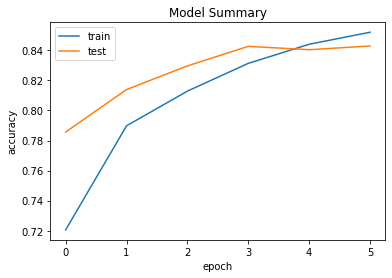

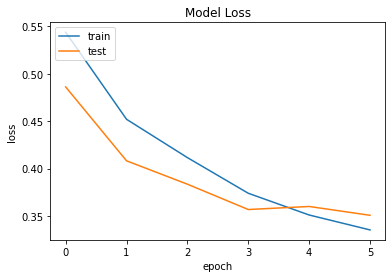

In [33]:
import matplotlib.pyplot as plt 

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title("Model Summary")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title("Model Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()
